## Introduction

- This file contains data processing and classification task for mobile phones price classification.
- In current implementation problematic columns/attributes from EDA stage (columns containing multicolinearity and unnatural values) will be ommited from training dataset.
- Existing outliers will be replaced with value of the closest percentile.

Classification will be carrioed out using following algorithms:
- Decision tree
- Random forrest
- Support Vector Machine
- K-Nearest Neighbors

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

module_path = os.path.abspath(os.path.join('./src/'))
module_path
if module_path not in sys.path:
    sys.path.append(module_path)

from graphs import categorical_vs_target_rep, model_comparison_heatmap
from dt_hyperparams_selection import optimal_min_samples_split_dt, optimal_min_samples_leaf_dt, optimal_max_depth_dt
from rf_hyperparams_selection import optimal_max_depth_rf, optimal_n_estimators_rf, optimal_min_samples_leaf_rf, optimal_min_samples_split_rf

warnings.simplefilter (action = 'ignore')
pd.set_option('display.max_columns', 22)

***
#### Load data
***

In [2]:
data_df = pd.read_csv('data/train.csv')
data_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


***
#### Remove columns from dataset
***

Columns columns containing multicolinearity and unnatural values **(pc, fc, px_width, px_height, sc_w, sc_h)** will be ommited from training dataset.

In [3]:
train_df = data_df.drop(columns=['pc', 'fc', 'px_width', 'px_height', 'sc_w', 'sc_h'] , axis = 1)
train_df.head()

,battery_power,blue,clock_speed,dual_sim,four_g,int_memory,m_dep,mobile_wt,n_cores,ram,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,0,7,0.6,188,2,2549,19,0,0,1,1
1,1021,1,0.5,1,1,53,0.7,136,3,2631,7,1,1,0,2
2,563,1,0.5,1,1,41,0.9,145,5,2603,9,1,1,0,2
3,615,1,2.5,0,0,10,0.8,131,6,2769,11,1,0,0,2
4,1821,1,1.2,0,1,44,0.6,141,2,1411,15,1,1,0,1


***
## Decision tree
***

#### Find test size with highest accuracy

In [4]:
x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1 , 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

accuracy_df = pd.DataFrame(columns=['Test Size', 'Accuracy'])

for i in np.arange(0.1, 0.35, 0.01):
    x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                        y,
                                                        test_size = round(i, 2),
                                                        random_state = 0)

    DTs = DecisionTreeClassifier(random_state = 0)
    DTs.fit(x_train, y_train.ravel())
    y_pred = DTs.predict(x_test) 

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    accuracy_df = accuracy_df.append({
        'Test Size': round(i, 2),
        'Accuracy': accuracy_score}, 
        ignore_index=True)

highest_accuracy = accuracy_df.nlargest(5, 'Accuracy') 
highest_accuracy

,Test Size,Accuracy
0,0.10,0.780000
16,0.26,0.771154
3,0.13,0.769231
1,0.11,0.763636
4,0.14,0.760714


#### Hyperparameter tuning with GridSearchCV

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.10,
                                                    random_state = 0)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 30),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20)
}  

DTs = DecisionTreeClassifier(random_state = 0)
clf = GridSearchCV(DTs, param_grid, cv = 5, n_jobs = -1)

clf.fit(x_train, y_train.ravel())

print(clf.best_params_) 

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 19, 'min_samples_split': 2}


**Applying hyperparameters recommended by GridSearchCV**

Entropy

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.10, random_state = 0)

DTsE = DecisionTreeClassifier(criterion = clf.best_params_["criterion"],
                              max_depth = clf.best_params_["max_depth"],
                              min_samples_leaf = clf.best_params_["min_samples_leaf"],
                              min_samples_split = clf.best_params_["min_samples_split"],
                              random_state = 0)

DTsE.fit(x_train, y_train.ravel())
y_pred = DTsE.predict(x_test) 

print(f'Accuracy with {clf.best_params_["criterion"]} criterion: ', metrics.accuracy_score(y_test, y_pred))

Accuracy with entropy criterion:  0.765


Gini

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.10, random_state = 0)

DTsG = DecisionTreeClassifier(criterion = 'gini',
                              max_depth = clf.best_params_["max_depth"],
                              min_samples_leaf = clf.best_params_["min_samples_leaf"],
                              min_samples_split = clf.best_params_["min_samples_split"],
                              random_state = 0)

DTsG.fit(x_train, y_train.ravel())
y_pred = DTsG.predict(x_test) 

print('Accuracy with gini criterion: ', metrics.accuracy_score(y_test, y_pred))

Accuracy with gini criterion:  0.785


Hyperparameters recommended by GridSearchCV do not improve model accuracy. 
<br> In fact, accuracy with 'gini' criterion is higher than with 'entropy' criterion.
<br> Following steps will atempt to find best hyperparameters manually

#### Manual hyperparameters selection

In [8]:
x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1 , 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.10,
                                                    random_state = 0)

values_1 = range(1, 30)
values_2 = range (2 , 30)

# 1. Defining optimal Max Depth
md = optimal_max_depth_dt(values_1, 'gini', 0, x_train, y_train, x_test, y_test)

# 2. Defining optimal Min Samples Leaf
msl = optimal_min_samples_leaf_dt(values_1, 'gini', md, 0, x_train, y_train, x_test, y_test)

# 3. Defining optimal Min Samples Split
mss = optimal_min_samples_split_dt(values_2, 'gini', md, msl, 0, x_train, y_train, x_test, y_test)


Max Depth value with highest model accuracy: 6


max_values    6.000
Accuracy      0.805
Name: 5, dtype: float64

Min Samples Leaf value with highest model accuracy: 25


leaf_values    25.00
Accuracy        0.82
Name: 24, dtype: float64

Min Samples Split value with hichest model accuracy: 2


split_values    2.00
Accuracy        0.82
Name: 0, dtype: float64

#### Final model

In [9]:
model_name = 'Decision tree'

DTsF = DecisionTreeClassifier(criterion = 'gini',
                              random_state = 0,
                              max_depth = md,
                              min_samples_leaf = msl,
                              min_samples_split = mss)

DTsF.fit(x_train, y_train.ravel())
y_pred = DTsF.predict(x_test)

print (f'Final version of {model_name} model accuracy : {metrics.accuracy_score(y_test , y_pred)}')
print (classification_report(y ,DTsF.predict(x_norm)))

Final version of Decision tree model accuracy : 0.82
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       500
           1       0.80      0.78      0.79       500
           2       0.74      0.82      0.78       500
           3       0.92      0.84      0.88       500

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



#### Comparison

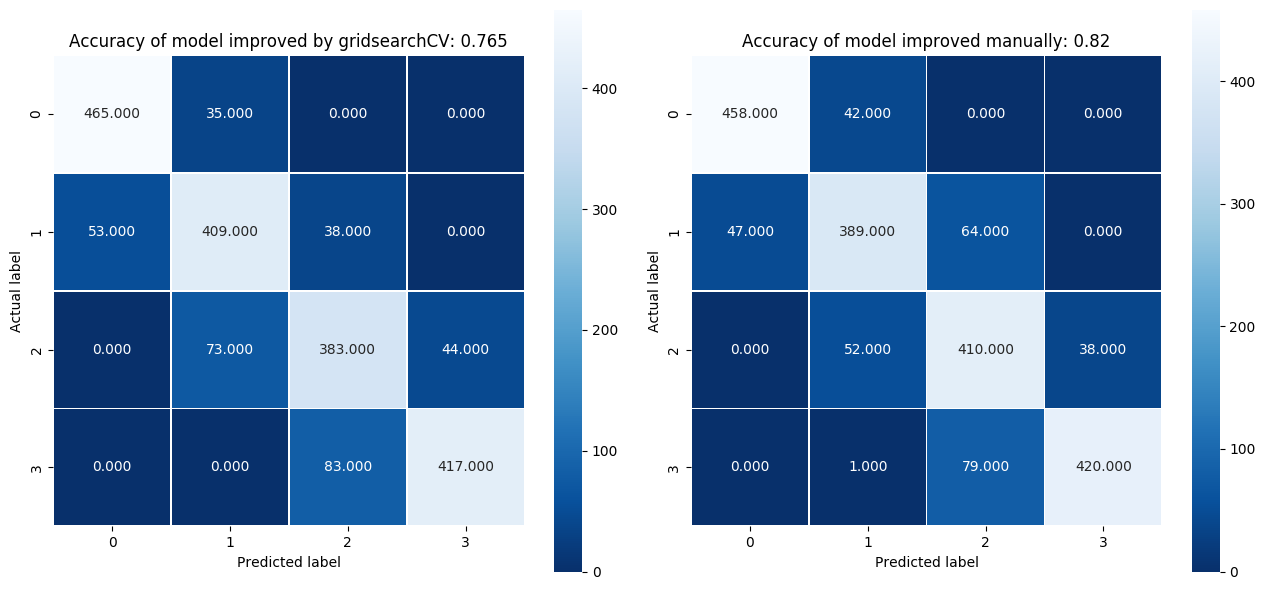

In [10]:
cm_dt_1 = confusion_matrix(y, DTsE.predict(x_norm))
score_dt_1 = round(DTsE.score(x_test, y_test), 3)

cm_dt_2 = confusion_matrix(y, DTsF.predict(x_norm))
score_dt_2 = round(DTsF.score(x_test, y_test), 3)


model_comparison_heatmap(cm_dt_1, cm_dt_2, score_dt_1, score_dt_2)

***
## Random forest
***

#### Find test size with highest accuracy

In [11]:
x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1, 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

accuracy_df = pd.DataFrame(columns=['Test Size', 'Accuracy'])
for i in np.arange(0.1, 0.35, 0.01):
    x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                        y,
                                                        test_size = round(i, 2),
                                                        random_state = 0)

    RF = RandomForestClassifier(random_state = 0) 
    RF.fit(x_train, y_train.ravel())
    y_pred = RF.predict(x_test)

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    accuracy_df = accuracy_df.append({
        'Test Size': round(i, 2),
        'Accuracy': accuracy_score},
        ignore_index=True)

highest_accuracy = accuracy_df.nlargest(5, 'Accuracy') 
highest_accuracy

,Test Size,Accuracy
2,0.12,0.775000
14,0.24,0.772917
5,0.15,0.760000
17,0.27,0.759259
7,0.17,0.758824


#### First model

In [12]:
model_name = 'Random Forest'

x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1 , 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.12,
                                                    random_state = 0)

RF1 = RandomForestClassifier(random_state = 0) 
RF1.fit(x_train, y_train.ravel())
y_pred = RF1.predict (x_test)

print(f'First version of {model_name} model accuracy : {metrics.accuracy_score(y_test, y_pred)}')
print(classification_report(y ,RF.predict(x_norm)))

First version of Random Forest model accuracy : 0.775
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       500
           1       0.87      0.90      0.89       500
           2       0.89      0.84      0.86       500
           3       0.93      0.92      0.93       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



#### Manual hyperparameters selection

In [13]:
x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1, 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.12,
                                                    random_state = 0)
max_depth_values = range(3, 30)
n_estimators_values = range(50, 250)
min_samples_leaf_values = range(2, 30)
min_samples_split_values = range(2, 20)

# 1. Defining optimal Max Depth
md = optimal_max_depth_rf(max_depth_values, 0, x_train, y_train, x_test, y_test)

# 2. Defining optimal N Estimators value
n_e = optimal_n_estimators_rf(n_estimators_values, 0, md, x_train, y_train, x_test, y_test)

# 3. Defining optimal Mean Samples Leaf value
msl = optimal_min_samples_leaf_rf(min_samples_leaf_values, 0, md, n_e, x_train, y_train, x_test, y_test)

# 4. Defining optimal Mean Samples Split value
mss = optimal_min_samples_split_rf(min_samples_leaf_values, 0, md, n_e, x_train, y_train, x_test, y_test)

Max Depth value with highest model accuracy: 8


max_depth_values    8.0000
Accuracy            0.7875
Name: 5, dtype: float64

N Estimators value with highest model accuracy: 71


n_estimators_values    71.0000
Accuracy                0.8125
Name: 21, dtype: float64

Mean Samples Leaf value with highest model accuracy: 2


min_samples_leaf_values    2.000000
Accuracy                   0.808333
Name: 0, dtype: float64

Mean Samples Split value with highest model accuracy: 3


split_values    3.000000
Accuracy        0.820833
Name: 1, dtype: float64

#### Final model

In [14]:
model_name = 'Random Forest'

x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1 , 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.12,
                                                    random_state = 0)

RF = RandomForestClassifier(random_state = 0,
                            max_depth = md,
                            n_estimators = n_e,
                            min_samples_split = mss) 

RF.fit(x_train, y_train.ravel())
y_pred = RF.predict (x_test)

print(f'Final version of {model_name} model accuracy : {metrics.accuracy_score(y_test, y_pred)}')
print(classification_report(y ,RF.predict(x_norm)))

Final version of Random Forest model accuracy : 0.8208333333333333
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       500
           1       0.90      0.89      0.89       500
           2       0.89      0.89      0.89       500
           3       0.96      0.96      0.96       500

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



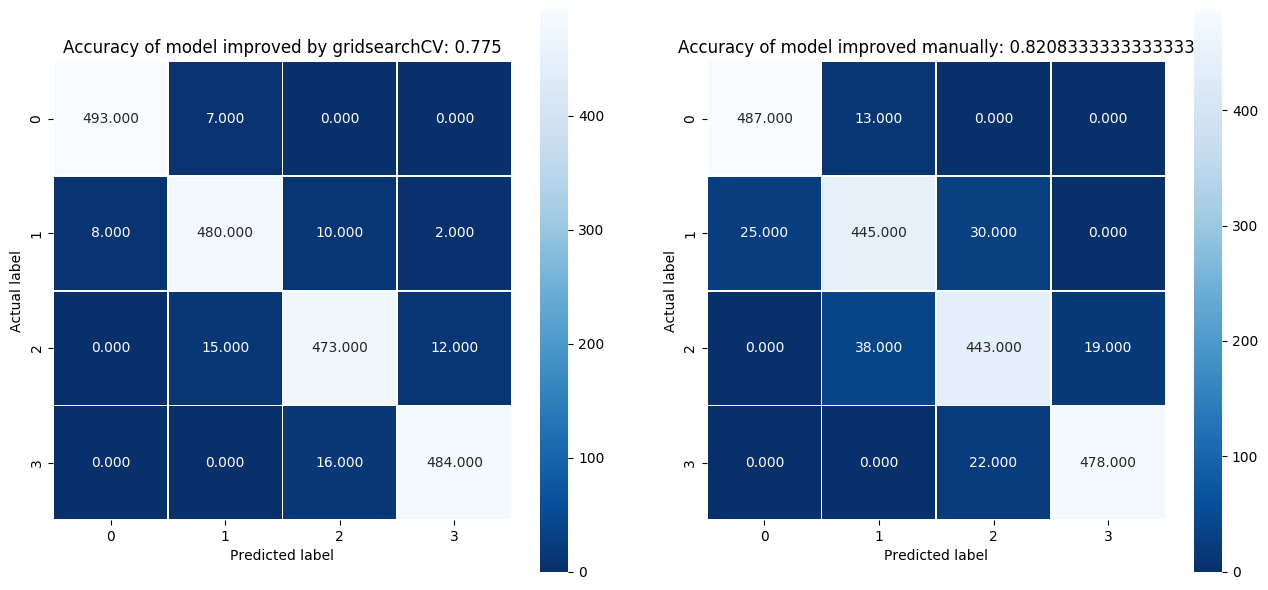

In [15]:
cm_rf_1 = confusion_matrix (y , RF1.predict (x_norm))
score_rf_1 = RF1.score(x_test, y_test)

cm_rf_2 = confusion_matrix (y , RF.predict (x_norm))
score_rf_2 = RF.score(x_test, y_test)

model_comparison_heatmap(cm_rf_1, cm_rf_2, score_rf_1, score_rf_2)

***
## Support Vector Machine
***

#### Find test size with highest accuracy

In [16]:
x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1, 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

accuracy_df = pd.DataFrame(columns=['Test Size', 'Accuracy'])

for i in np.arange(0.10, 0.35, 0.01):
    x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                        y,
                                                        test_size = round(i, 2),
                                                        random_state = 0)


    SVM = SVC() 
    SVM.fit(x_train, y_train.ravel())
    y_pred = SVM.predict(x_test)

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    accuracy_df = accuracy_df.append({
        'Test Size': round(i, 2),
        'Accuracy': accuracy_score}, 
        ignore_index=True)


highest_accuracy = accuracy_df.nlargest(5, 'Accuracy') 
highest_accuracy

,Test Size,Accuracy
0,0.10,0.815000
4,0.14,0.814286
5,0.15,0.810000
9,0.19,0.807895
10,0.20,0.807500


#### First model

In [17]:
model_name = 'SVM'

x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1 , 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0)

SVM1 = SVC() 
SVM1.fit(x_train, y_train.ravel())
y_pred = SVM1.predict(x_test)

print(f'First version of {model_name} model accuracy : {metrics.accuracy_score(y_test, y_pred)}')
print(classification_report(y, SVM1.predict(x_norm)))

First version of SVM model accuracy : 0.815
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       500
           1       0.84      0.88      0.86       500
           2       0.84      0.83      0.84       500
           3       0.93      0.91      0.92       500

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



#### Hyperparameter tuning with GridSearchCV

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': range(1 , 100)
    }  

SVM = SVC() 
clf = GridSearchCV(SVM, param_grid, cv=5, n_jobs = -1, scoring='accuracy')

clf.fit(x_train, y_train.ravel())
print(clf.best_params_) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

{'C': 14, 'kernel': 'linear'}


**Applying hyperparameters recommended by GridSearchCV**

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0)

SVM_L = SVC(C = clf.best_params_["C"],
          kernel = clf.best_params_["kernel"]) 
SVM_L.fit(x_train, y_train.ravel())
y_pred = SVM_L.predict(x_test)

print("Accuracy : " , metrics.accuracy_score(y_test, y_pred))

Accuracy :  0.84


#### Manual hyperparameters selection

In [20]:
C_val = range(1 , 50)
accuracy_values = []

for val in C_val:
    SVM = SVC (kernel = 'linear', C = val) 
    SVM.fit (x_train , y_train.ravel())
    y_pred = SVM.predict (x_test)
    accuracy = metrics.accuracy_score (y_test, y_pred)
    accuracy_values.append(accuracy)

c_val_df = pd.DataFrame({
    'C_values': C_val,
    'Accuracy': accuracy_values
})

hghst_acc_c = c_val_df.nlargest(3, 'Accuracy') 
hghst_acc_c

,C_values,Accuracy
5,6,0.84
6,7,0.84
7,8,0.84


#### Final model

In [21]:
model_name = 'SVM'

x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0)

SVM = SVC(kernel = 'linear', C = 6) 
SVM.fit(x_train, y_train.ravel())
y_pred = SVM.predict(x_test)

print(f'Final version of {model_name} model accuracy : {metrics.accuracy_score(y_test, y_pred)}')
print(classification_report(y, SVM.predict(x_norm)))

Final version of SVM model accuracy : 0.84
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       500
           1       0.79      0.80      0.80       500
           2       0.78      0.73      0.76       500
           3       0.87      0.89      0.88       500

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



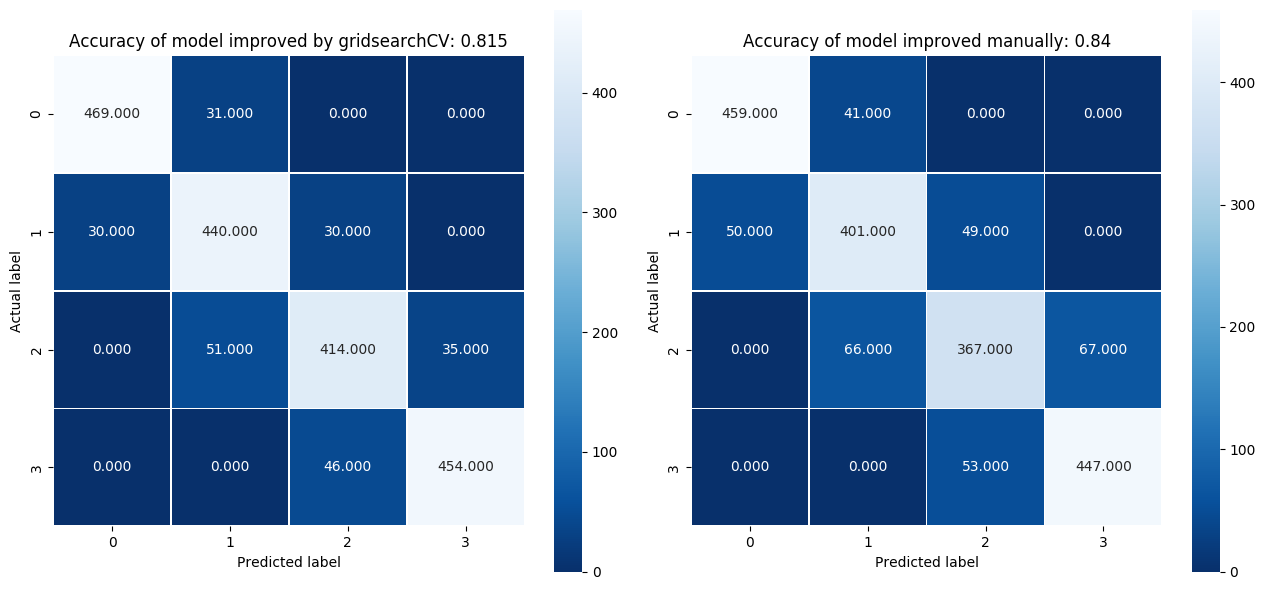

In [22]:
cm_svm_1 = confusion_matrix(y, SVM1.predict(x_norm))
score_svm_1 = SVM1.score(x_test, y_test)

cm_svm_2 = confusion_matrix(y, SVM.predict(x_norm))
score_svm_2 = SVM.score(x_test, y_test)

model_comparison_heatmap(cm_svm_1, cm_svm_2, score_svm_1, score_svm_2)

***
## K-Nearest Neighbours
***

#### Find test size with highest accuracy

In [23]:
x = train_df.drop('price_range', axis = 1)
y = train_df.price_range.values.reshape(-1 , 1)

Scaler = StandardScaler()
x_norm = Scaler.fit_transform(x)

accuracy_df = pd.DataFrame(columns=['Test Size', 'Accuracy'])

for i in np.arange(0.1, 0.35, 0.01):
    x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                        y,
                                                        test_size = round(i, 2),
                                                        random_state = 0)

    KNN = KNeighborsClassifier(n_neighbors=4)
    KNN.fit(x_train, y_train)
    y_pred = KNN.predict(x_test)

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    accuracy_df = accuracy_df.append({
        'Test Size': round(i, 2),
        'Accuracy': accuracy_score}, 
        ignore_index=True)


highest_accuracy = accuracy_df.nlargest(5, 'Accuracy') 
highest_accuracy

,Test Size,Accuracy
1,0.11,0.522727
2,0.12,0.520833
7,0.17,0.520588
5,0.15,0.513333
3,0.13,0.511538


#### First model

In [24]:
model_name = 'K-Nearest Neighbours'

x = train_df.drop('price_range', axis=1)
y = train_df['price_range']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.11,
                                                    random_state=0)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

KNN_1 = KNeighborsClassifier(n_neighbors=5)
KNN_1.fit(x_train_scaled, y_train)
y_pred = KNN_1.predict(x_test_scaled)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5272727272727272


#### Hyperparameter tuning with GridSearchCV

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0)

param_grid = {'n_neighbors': range(1, 21)}

KNN = KNeighborsClassifier()

clf = GridSearchCV(KNN, param_grid, cv=5, scoring='accuracy')
clf.fit(x_train, y_train)

best_n_neighbors = clf.best_params_['n_neighbors']
print("Best n_neighbors:", best_n_neighbors)

Best n_neighbors: 18


#### Final model

In [26]:
model_name = 'K-Nearest Neighbours'

x = train_df.drop('price_range', axis=1)
y = train_df['price_range']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.11,
                                                    random_state=0)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

KNN_F = KNeighborsClassifier(n_neighbors=best_n_neighbors)
KNN_F.fit(x_train_scaled, y_train)
y_pred = KNN_F.predict(x_test_scaled)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y, KNN_F.predict(x_norm)))

Accuracy: 0.5636363636363636
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       500
           1       0.56      0.57      0.56       500
           2       0.59      0.57      0.58       500
           3       0.83      0.74      0.78       500

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



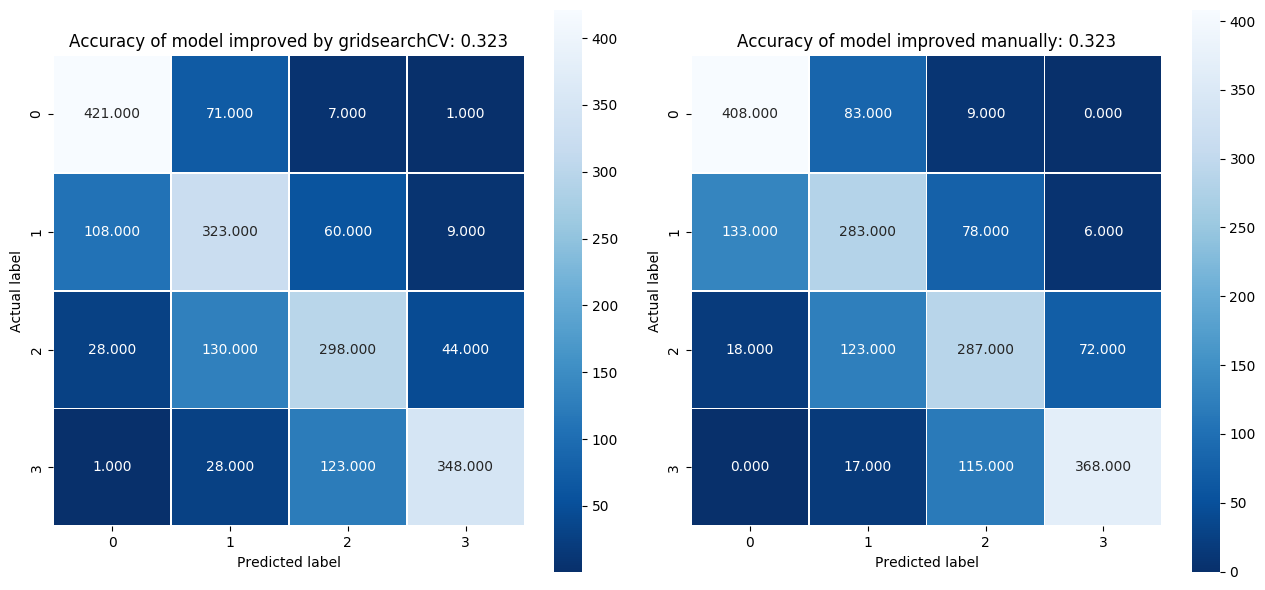

In [27]:
cm_knn_1 = confusion_matrix(y, KNN_1.predict(x_norm))
score_knn_1 = round(KNN_1.score(x_test, y_test), 3)

cm_knn_2 = confusion_matrix(y, KNN_F.predict(x_norm))
score_knn_2 = round(KNN_F.score(x_test, y_test), 3)

model_comparison_heatmap(cm_knn_1, cm_knn_2, score_knn_1, score_knn_2)

***
## Model comparison
***

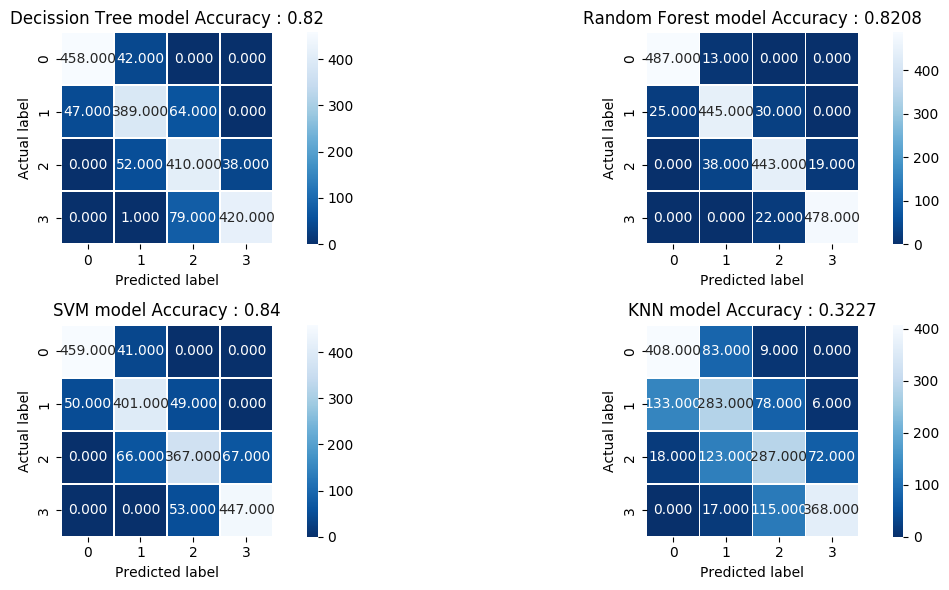

In [28]:
# Data

# 1. Decission Tree
x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0)

DTs = DecisionTreeClassifier(criterion = 'gini',
                             max_depth = 6,
                             min_samples_leaf = 25,
                             random_state = 0,
                             min_samples_split = 2)

DTs.fit(x_train, y_train.ravel())
cm1 = confusion_matrix(y, DTs.predict(x_norm))
score1 = round(DTs.score(x_test, y_test), 4)

# 2. Random Forest
x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.12,
                                                    random_state = 0)

RF = RandomForestClassifier(random_state = 0,
                            n_estimators = 71,
                            max_depth = 8,
                            min_samples_split = 3) 

RF.fit(x_train, y_train.ravel())
y_pred = RF.predict(x_test)
cm2 = confusion_matrix(y, RF.predict(x_norm))
score2 = round(RF.score(x_test, y_test), 4)

# 3. SVM
x_train, x_test, y_train, y_test = train_test_split(x_norm,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 0)

SVM = SVC(kernel = 'linear', C = 6) 

SVM.fit(x_train, y_train.ravel())
y_pred = SVM.predict(x_test)
cm3 = confusion_matrix(y, SVM.predict(x_norm))
score3 = round(SVM.score(x_test, y_test), 4)

# 4.KNN
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.11,
                                                    random_state=0)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

KNN = KNeighborsClassifier(n_neighbors=best_n_neighbors)
KNN.fit(x_train_scaled, y_train)
y_pred = KNN.predict(x_test_scaled)

cm4 = confusion_matrix(y, KNN.predict(x_norm))
score4 = round(KNN.score(x_test, y_test), 4)


# Plots

fig = plt.figure(figsize = (13, 6))

# 1. Decission Tree
plt.subplot(2, 2, 1)
sns.heatmap(cm1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Decission Tree model Accuracy : {0}'.format(score1)
plt.title(all_sample_title, size = 12)

# 2. Random Forest
plt.subplot(2, 2, 2)
sns.heatmap(cm2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Random Forest model Accuracy : {0}'.format(score2)
plt.title(all_sample_title, size = 12)

# 3. SVM
plt.subplot(2, 2, 3)
sns.heatmap(cm3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'SVM model Accuracy : {0}'.format(score3)
plt.title(all_sample_title, size = 12)

# 4. KNN
plt.subplot(2, 2, 4)
sns.heatmap(cm4, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'KNN model Accuracy : {0}'.format(score4)
plt.title(all_sample_title, size = 12)

plt.tight_layout()
plt.show()


***
## Test dataset prediction
***

#### Load data

In [29]:
test_df = pd.read_csv ("data/test.csv")
test_df.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


#### EDA

**Describe dataset**

In [30]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1000.0,500.5000,288.819436,1.0,250.75,500.5,750.25,1000.0
battery_power,1000.0,1248.5100,432.458227,500.0,895.00,1246.5,1629.25,1999.0
blue,1000.0,0.5160,0.499994,0.0,0.00,1.0,1.00,1.0
clock_speed,1000.0,1.5409,0.829268,0.5,0.70,1.5,2.30,3.0
dual_sim,1000.0,0.5170,0.499961,0.0,0.00,1.0,1.00,1.0
fc,1000.0,4.5930,4.463325,0.0,1.00,3.0,7.00,19.0
four_g,1000.0,0.4870,0.500081,0.0,0.00,0.0,1.00,1.0
int_memory,1000.0,33.6520,18.128694,2.0,18.00,34.5,49.00,64.0
m_dep,1000.0,0.5175,0.280861,0.1,0.30,0.5,0.80,1.0
mobile_wt,1000.0,139.5110,34.851550,80.0,109.75,139.0,170.00,200.0


**Check for missing values**

In [31]:
test_df.isna().sum()

id               0
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
dtype: int64

#### Remove columns from dataset

In [32]:
wrk_df = test_df.drop(columns=['pc', 'fc', 'px_width', 'px_height', 'sc_w', 'sc_h', 'id'], axis = 1)
wrk_df.head()

,battery_power,blue,clock_speed,dual_sim,four_g,int_memory,m_dep,mobile_wt,n_cores,ram,talk_time,three_g,touch_screen,wifi
0,1043,1,1.8,1,0,5,0.1,193,3,3476,2,0,1,0
1,841,1,0.5,1,1,61,0.8,191,5,3895,7,1,0,0
2,1807,1,2.8,0,0,27,0.9,186,3,2396,10,0,1,1
3,1546,0,0.5,1,1,25,0.5,96,8,3893,7,1,1,0
4,1434,0,1.4,0,1,49,0.5,108,6,1773,7,1,0,1


#### Applying SVM model

In [33]:
Scaler = StandardScaler()
test = Scaler.fit_transform(wrk_df)
y_test = SVM.predict(test)

y_test_df = pd.DataFrame(y_test)
y_test_df = y_test_df.rename(columns={0: 'price_range'})
y_test_df.head()

test_df['price_range'] = y_test_df['price_range']
test_df.head()


,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0,3
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0,3
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1,2
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0,3
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1,1


**Describe output dataset**

In [34]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1000.0,500.5000,288.819436,1.0,250.75,500.5,750.25,1000.0
battery_power,1000.0,1248.5100,432.458227,500.0,895.00,1246.5,1629.25,1999.0
blue,1000.0,0.5160,0.499994,0.0,0.00,1.0,1.00,1.0
clock_speed,1000.0,1.5409,0.829268,0.5,0.70,1.5,2.30,3.0
dual_sim,1000.0,0.5170,0.499961,0.0,0.00,1.0,1.00,1.0
fc,1000.0,4.5930,4.463325,0.0,1.00,3.0,7.00,19.0
four_g,1000.0,0.4870,0.500081,0.0,0.00,0.0,1.00,1.0
int_memory,1000.0,33.6520,18.128694,2.0,18.00,34.5,49.00,64.0
m_dep,1000.0,0.5175,0.280861,0.1,0.30,0.5,0.80,1.0
mobile_wt,1000.0,139.5110,34.851550,80.0,109.75,139.0,170.00,200.0


**Visualisations**

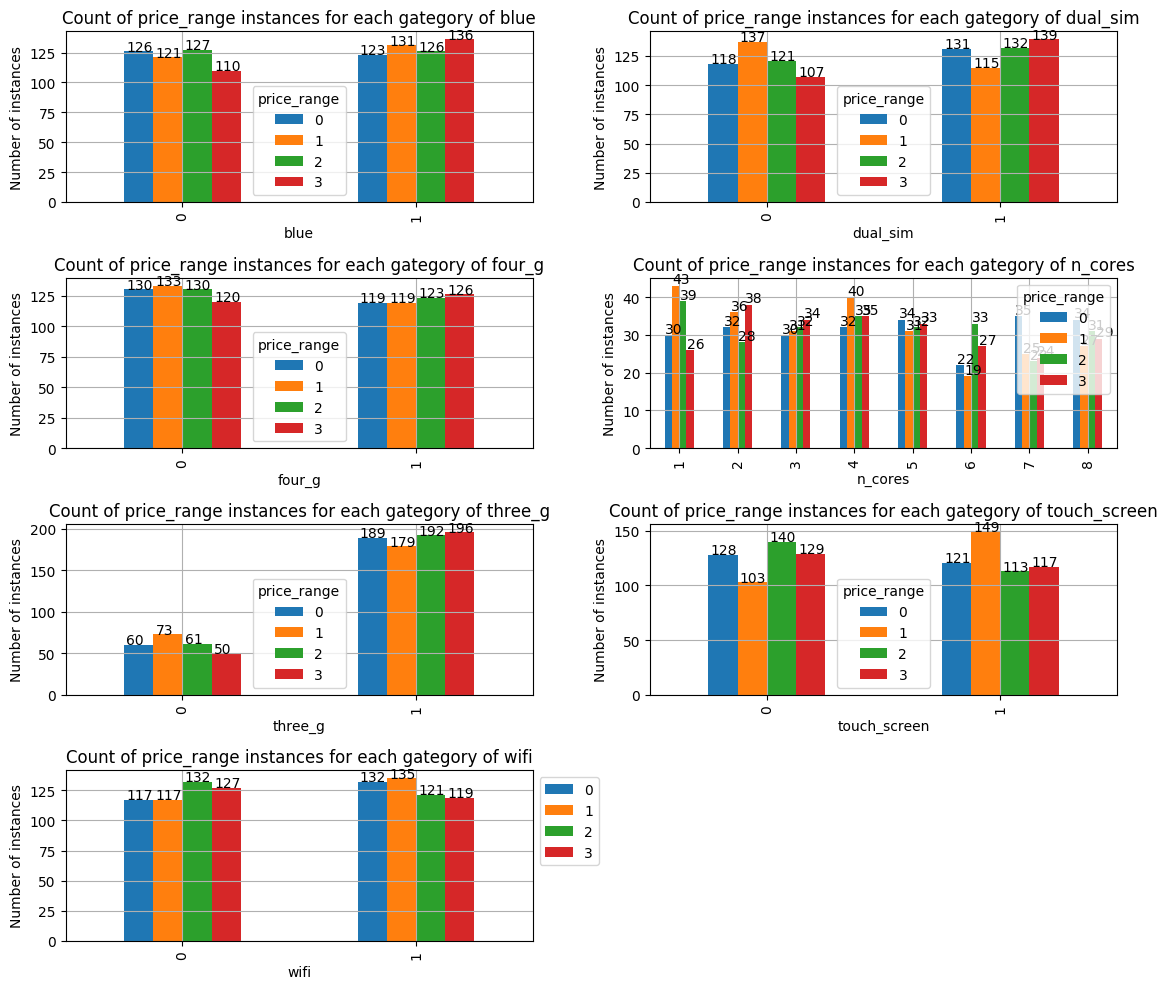

In [35]:
columns = ['blue', 'dual_sim','four_g','n_cores', 'three_g','touch_screen', 'wifi']
col_number = len(columns)

categorical_vs_target_rep(test_df, columns, 'price_range', col_number)